In [1]:
import pandas as pd

In [2]:
claimsData = pd.read_csv('/Volumes/Sina/PatentData/PatentClaims_PatentsView/g_claims_2009.tsv',sep='\t')

/var/folders/b9/yq8zjc151b32hypjzgpnmjfxd7tx3y/T/ipykernel_9149/2990836469.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  claimsData = pd.read_csv('/Volumes/Sina/PatentData/PatentClaims_PatentsView/g_claims_2009.tsv',sep='\t')


In [3]:
claimTextData = list(claimsData['claim_text'])
claimTextData = claimTextData[:10000]    # make it workable for now

In [4]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(claimTextData, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [7]:
# decreasing the dimensionality

import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [8]:
# clustering

import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

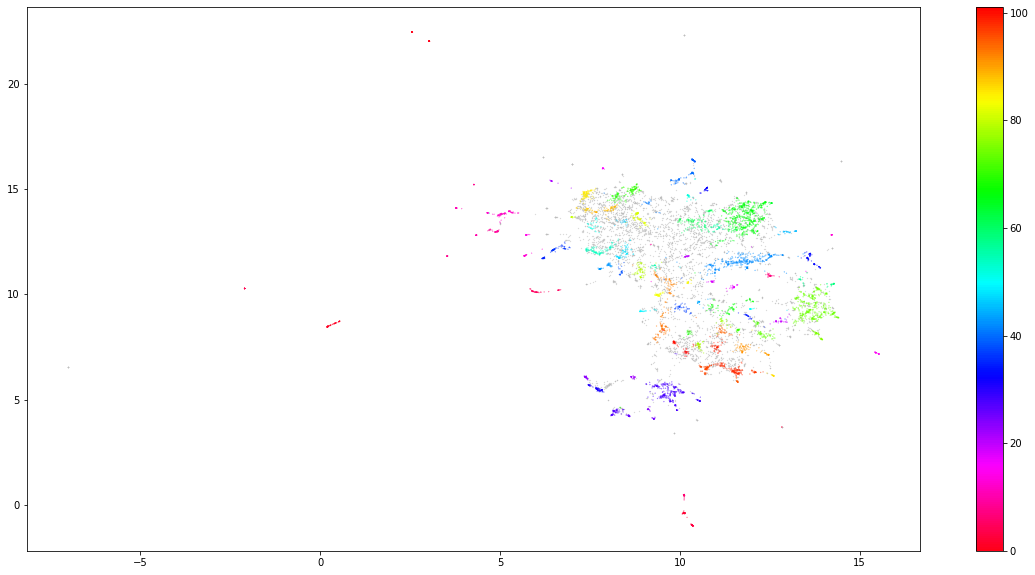

In [9]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [10]:
# Toward topic modeling

docs_df = pd.DataFrame(claimTextData, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [11]:
# TFIDF Score

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(claimTextData))

In [12]:
# Topic representation

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/Users/sikh2040/miniconda3/envs/d2l/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,4548
67,66,537
75,74,410
43,42,354
29,28,281
99,98,136
86,85,101
13,12,98
93,92,92
71,70,91


In [32]:
top_n_words[99][:20]

[('ether', 0.16179210185055432),
 ('solvent', 0.12979050566118114),
 ('acetate', 0.10917744876523226),
 ('tetrahydrofuran', 0.09153801075646348),
 ('acid', 0.08416710271013442),
 ('process', 0.08189572093534779),
 ('thereof', 0.07402116941836613),
 ('selected', 0.07113318274616962),
 ('diethyl', 0.062426682664110555),
 ('mixtures', 0.06031798627125967),
 ('consisting', 0.05914062904405341),
 ('toluene', 0.05890759908894093),
 ('butyl', 0.058642080221383536),
 ('acetonitrile', 0.05100447850647246),
 ('suitable', 0.0501070458583431),
 ('xylene', 0.04682001199808292),
 ('group', 0.04680711831757578),
 ('mtbe', 0.044026849835884056),
 ('thf', 0.04321756866846271),
 ('ethanol', 0.04249486939628879)]